In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import funcs
import coral
import star
import mcd
import dann
import base
import plots
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import precision_score,f1_score,recall_score
from torch.optim.lr_scheduler import StepLR

In [9]:
# Load testbed data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
file_path = "/home/ash.ali/ic3/testbed_da/data"

# Classes
class_subset = ["bpsk", "qpsk", "8psk", "4qam", "8qam", "16qam", "8apsk"]

# Split source, target
# try selecting some of the mods, not all
X = np.load(file_path + "/X_tbed.npy")
Y = np.load(file_path + "/Y_tbed.npy")

doppler_offset_source = 10
doppler_offset_target = 0

source_mask = (Y[:, 1] == doppler_offset_source)
target_mask = (Y[:, 1] == doppler_offset_target)

X_s = X[source_mask]
Y_s = Y[source_mask]
Y_s = Y_s[:,0]

X_t = X[target_mask]
Y_t = Y[target_mask]
Y_t = Y_t[:,0]

# Dataloaders
S_train_loader, S_val_loader = funcs.create_loader(X_s, Y_s, permute=False)
T_train_loader, T_val_loader = funcs.create_loader(X_t, Y_t, permute=False)

/cm/shared/apps/pytorch-py39-cuda11.8-gcc11/1.13.0/lib/python3.9/site-packages/torch/backends/cudnn/__init__.py:91: UserWarning: PyTorch was compiled without cuDNN/MIOpen support. To use cuDNN/MIOpen, rebuild PyTorch making sure the library is visible to the build system.
  warnings.warn(



Run 1/1
Epoch 1/25, Train Loss: 1.6250, Train Acc: 0.2996, Val Loss: 1.2016, Val Acc: 0.4267


/cm/shared/apps/pytorch-py39-cuda11.8-gcc11/1.13.0/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 2/25, Train Loss: 1.4254, Train Acc: 0.3891, Val Loss: 1.2267, Val Acc: 0.4148
Epoch 3/25, Train Loss: 1.2374, Train Acc: 0.4132, Val Loss: 1.1774, Val Acc: 0.4228
Epoch 4/25, Train Loss: 1.2927, Train Acc: 0.4142, Val Loss: 1.2244, Val Acc: 0.4157
Epoch 5/25, Train Loss: 1.2851, Train Acc: 0.4144, Val Loss: 1.2472, Val Acc: 0.4296
Epoch 6/25, Train Loss: 1.1917, Train Acc: 0.4252, Val Loss: 1.1705, Val Acc: 0.4220
Epoch 7/25, Train Loss: 1.2250, Train Acc: 0.4234, Val Loss: 1.1799, Val Acc: 0.4201
Epoch 8/25, Train Loss: 1.1805, Train Acc: 0.4247, Val Loss: 1.1771, Val Acc: 0.4234
Epoch 9/25, Train Loss: 1.1792, Train Acc: 0.4242, Val Loss: 1.1878, Val Acc: 0.4330
Epoch 10/25, Train Loss: 1.1742, Train Acc: 0.4304, Val Loss: 1.1759, Val Acc: 0.4340
Epoch 11/25, Train Loss: 1.1796, Train Acc: 0.4263, Val Loss: 1.1854, Val Acc: 0.4214
Early stopping!


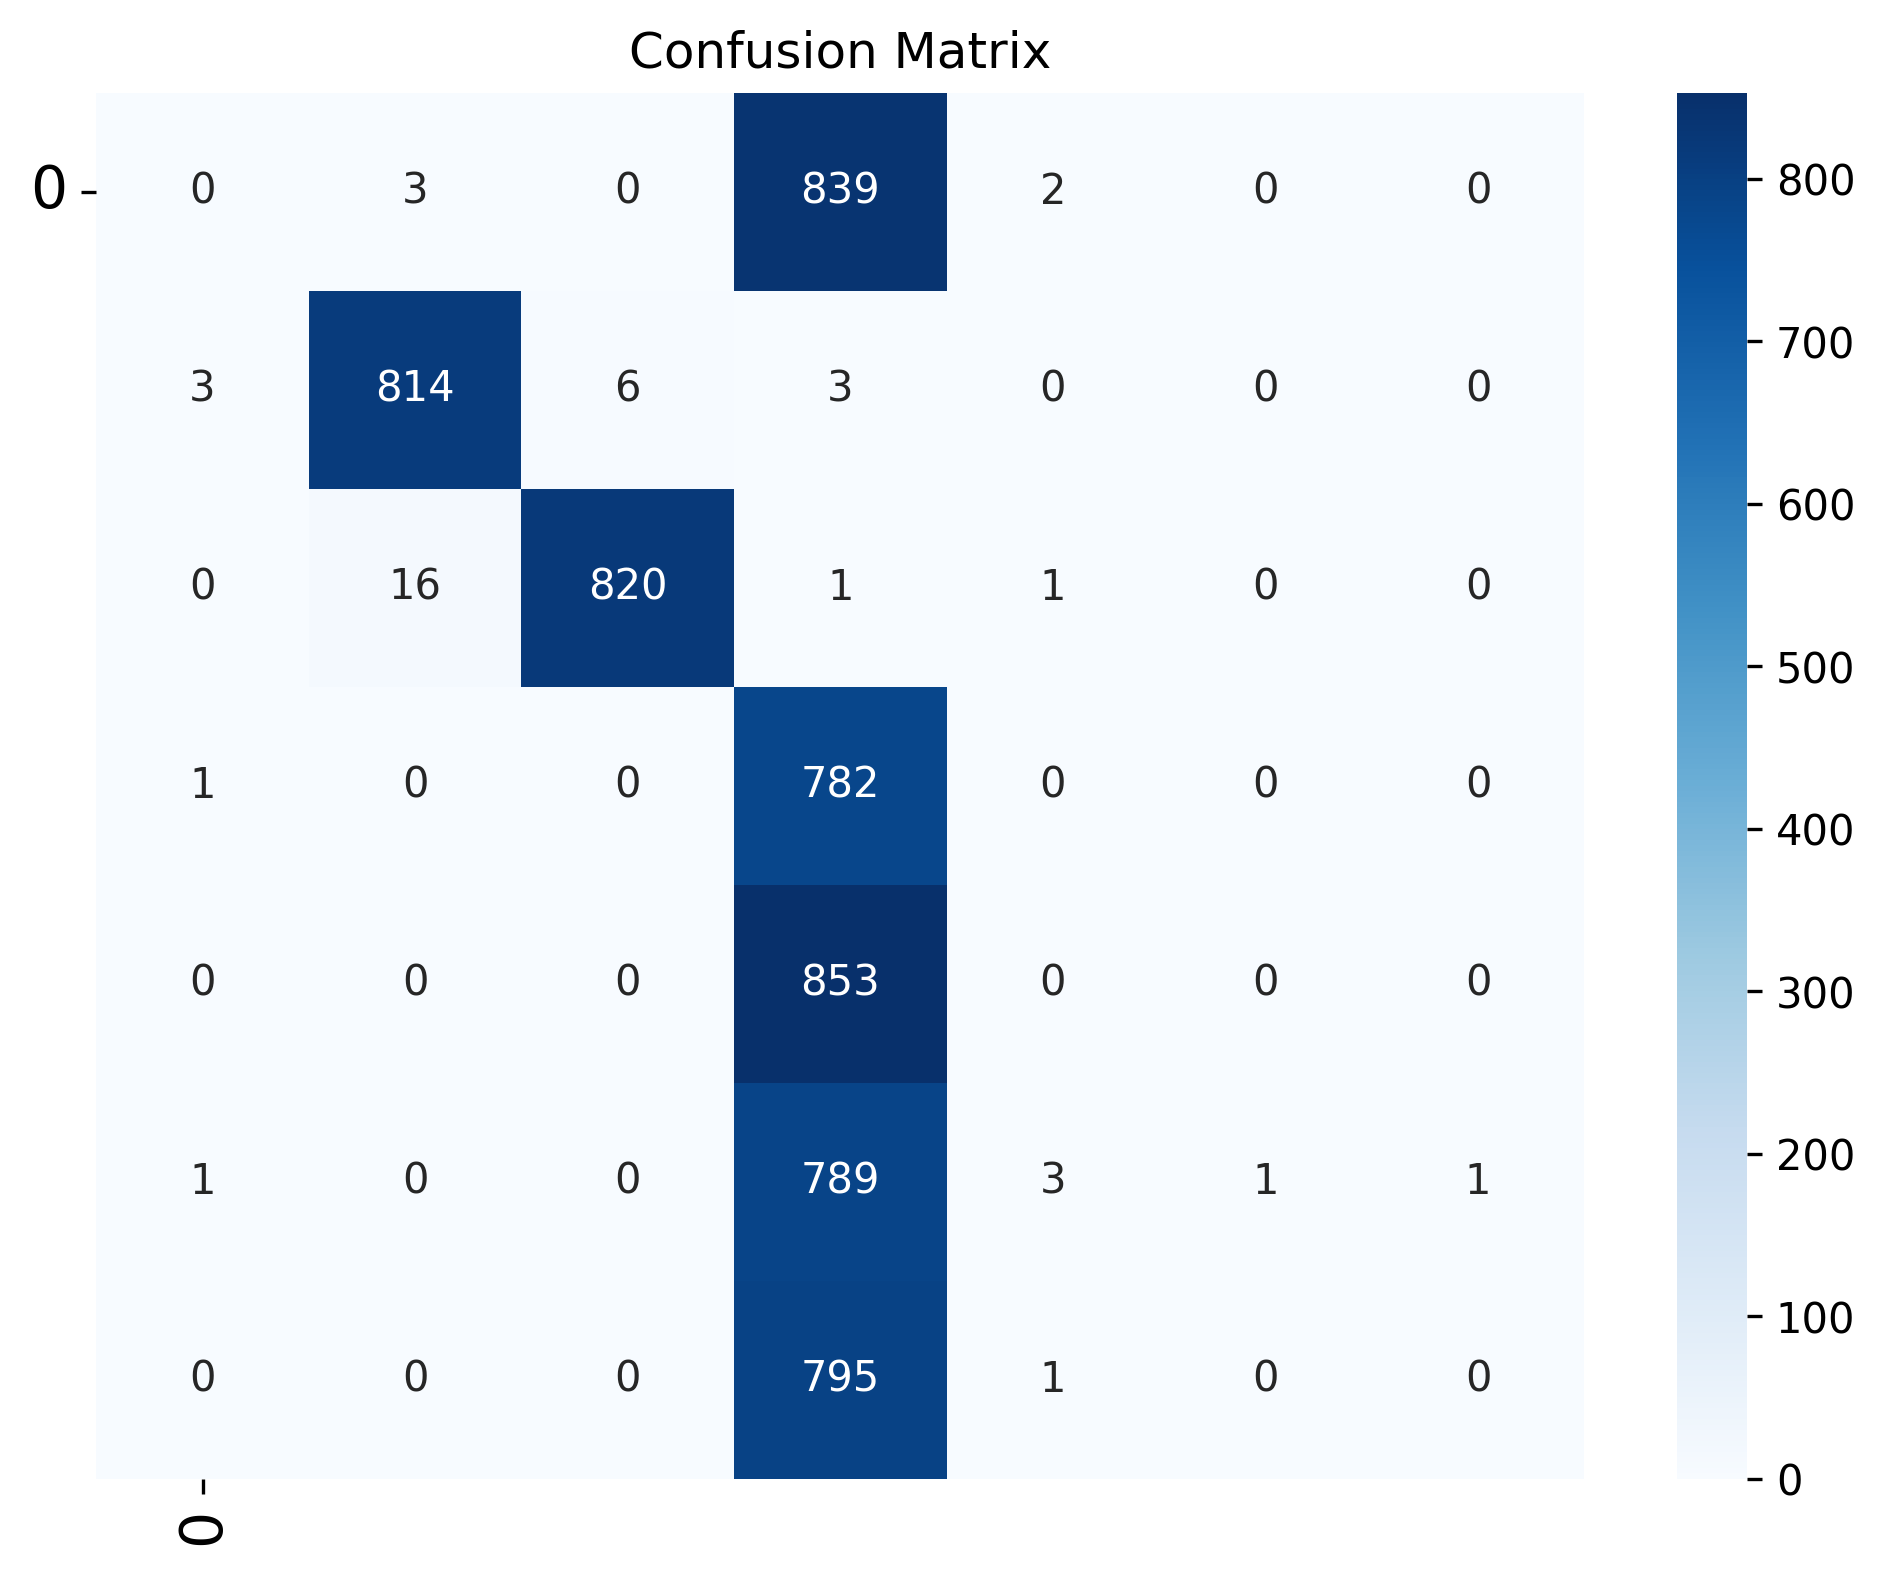

/cm/shared/apps/ml-pythondeps-py39-cuda11.8-gcc11/4.12.0/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


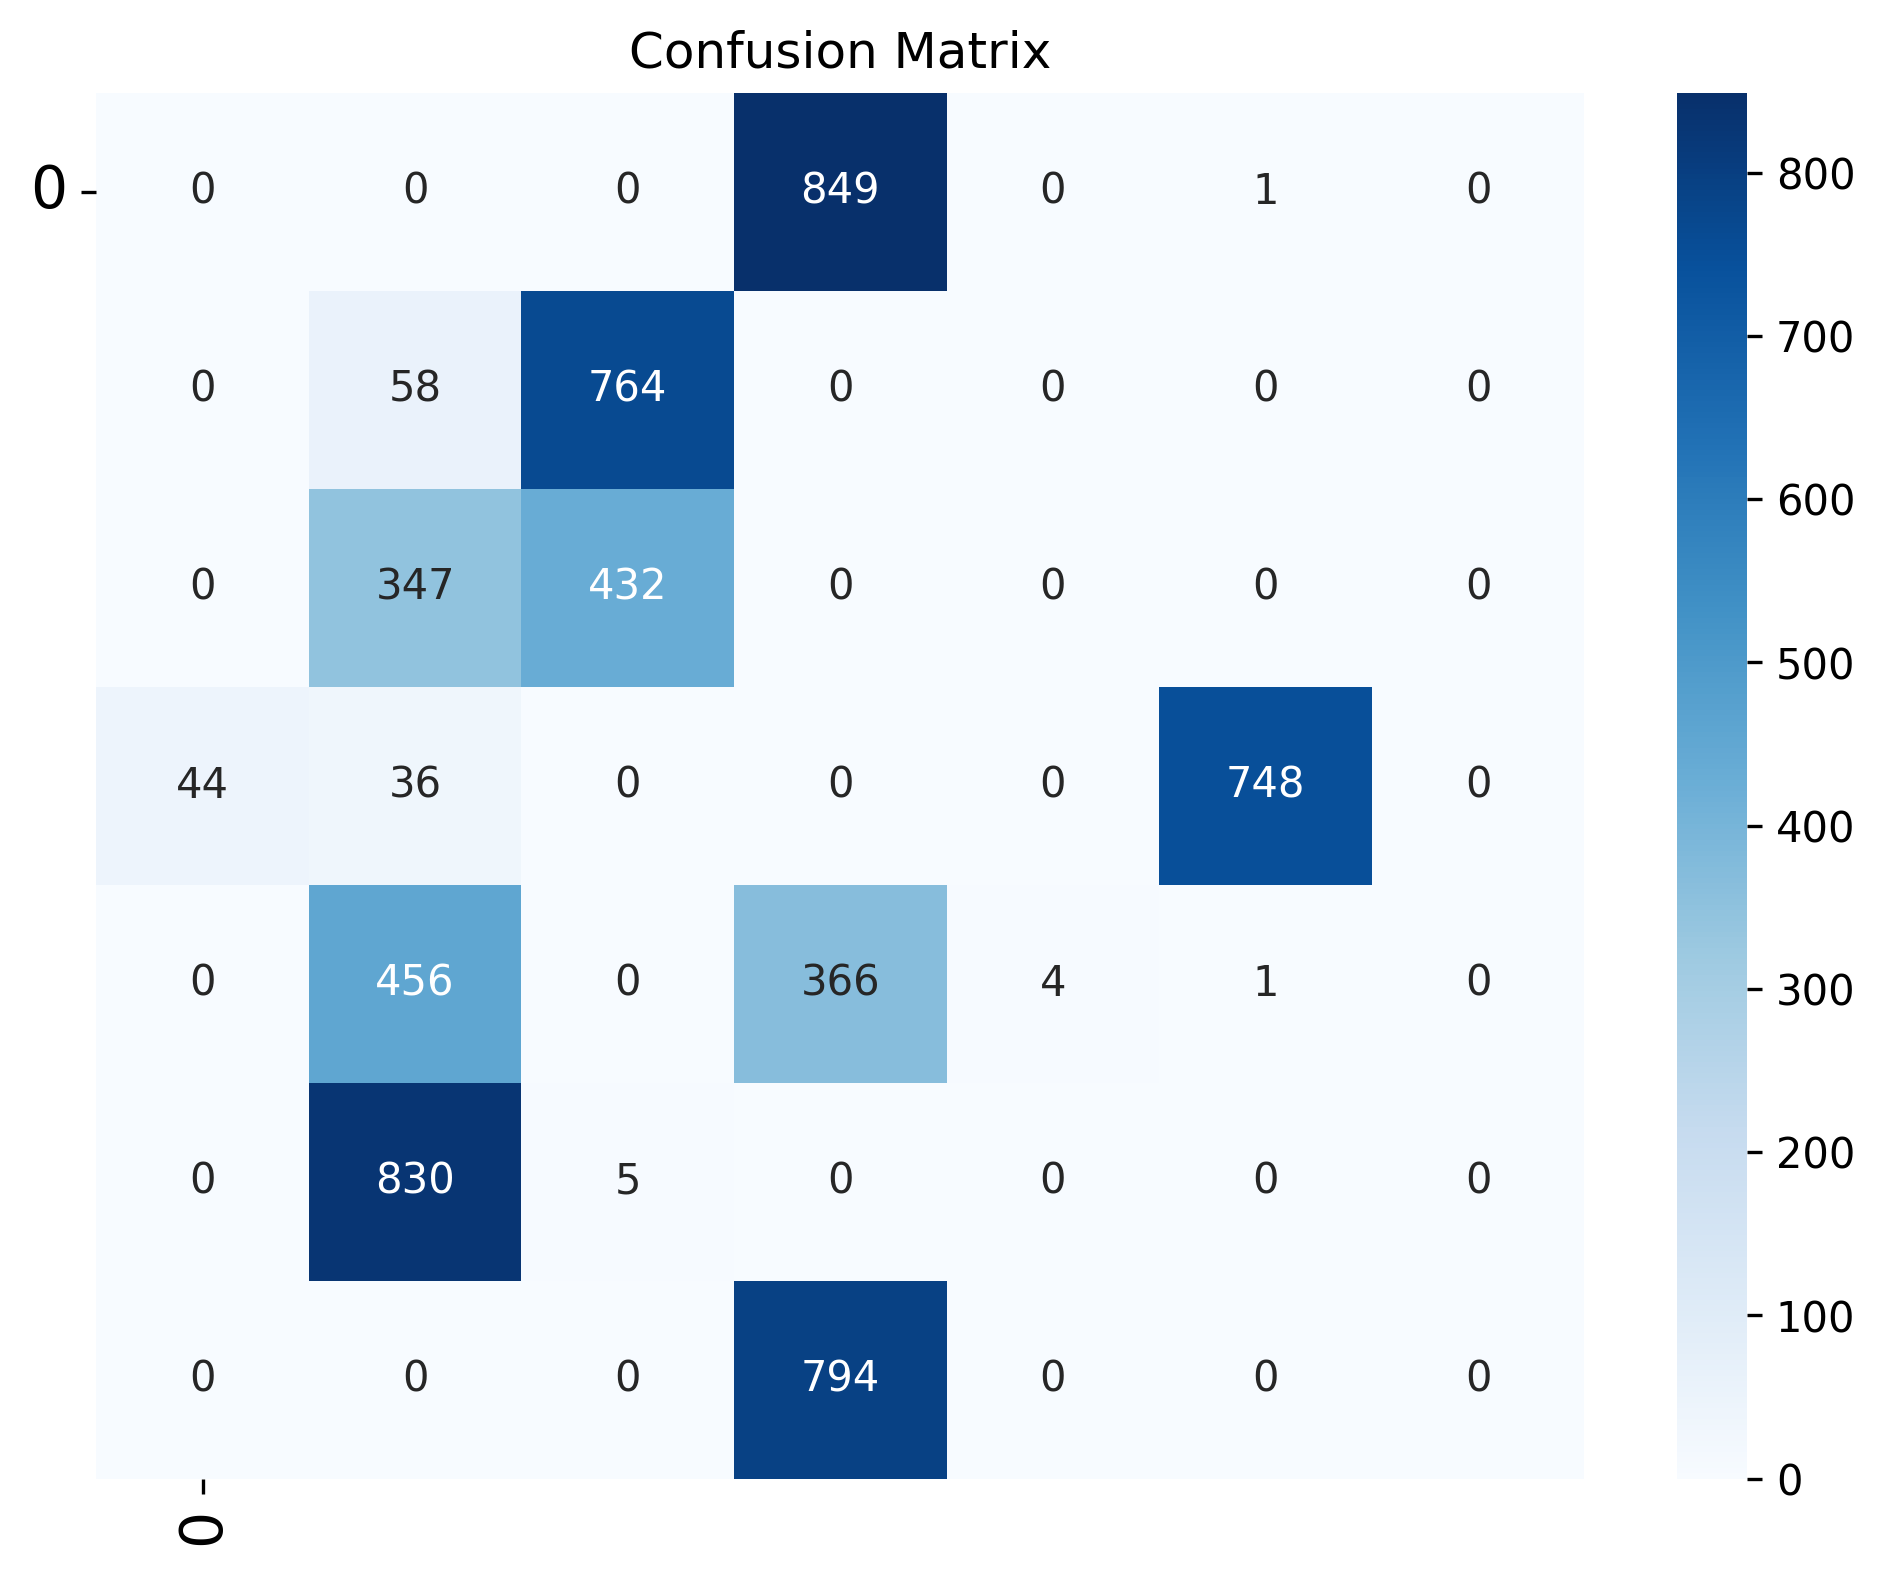


Source performance: 42.14 45.18 42.34 32.75
Target performance: 8.61 19.90 9.00 7.02

bpsk: 0.00
qpsk: 7.06
8psk: 55.46
4qam: 0.00
8qam: 0.48
16qam: 0.00
8apsk: 0.00


In [10]:
#%% Baseline - VTC24 code

# Hyperparameters
lr = 0.001
n_epochs = 25
n_runs = 1
n_classes = len(class_subset)

model = base.CLDNN().to(device) # Model selection
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=10, gamma=.1)

# Initialize lists to store performance metrics for each run
accuracy_s_list, pr_s_list, re_s_list, f1_s_list = [], [], [], []
accuracy_t_list, pr_t_list, re_t_list, f1_t_list = [], [], [], []
class_accuracies_s = np.zeros((n_runs, n_classes))
class_accuracies_t = np.zeros((n_runs, n_classes))

def train_model():
    best_val_loss = float('inf')
    patience = 5
    trigger_times = 0
    for epoch in range(n_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in S_train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        epoch_loss = running_loss / len(S_train_loader.dataset)
        train_accuracy = correct / total

        # Validation
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in S_val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_loss = val_running_loss / len(S_val_loader.dataset)
        val_accuracy = correct / total

        print(f'Epoch {epoch+1}/{n_epochs}, '
              f'Train Loss: {epoch_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

        scheduler.step()

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print('Early stopping!')
                break

    return model

def eva_model(model, loader, num_classes):
    # Evaluate model
    model.eval()
    true_labels = []
    predictions = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            class_outputs = model(inputs)
            _, preds = torch.max(class_outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

    # Performance metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='macro')
    recall = recall_score(true_labels, predictions, average='macro')
    f1 = f1_score(true_labels, predictions, average='macro')
    
    # Confusion matrix and per-class accuracy
    conf_mat = confusion_matrix(true_labels, predictions)
    class_accuracy = conf_mat.diagonal() / conf_mat.sum(axis=1)

    # Plot the confusion matrix
    plt.figure(figsize=(8,6),dpi=300)
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
                xticklabels=n_classes,
                yticklabels=n_classes)
    plt.yticks(fontsize=14,rotation=360)
    plt.xticks(fontsize=14,rotation=90)
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, precision, recall, f1, class_accuracy

for run in range(n_runs):
    print(f'\nRun {run+1}/{n_runs}')
    # Model is reset per run. Change model type here too.
    model = base.CLDNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    trained_model = train_model()

    # Evaluate on source domain
    accuracy_s, pr_s, re_s, f1_s, class_acc_s = eva_model(trained_model, S_val_loader, n_classes)
    accuracy_s_list.append(accuracy_s)
    pr_s_list.append(pr_s)
    re_s_list.append(re_s)
    f1_s_list.append(f1_s)
    class_accuracies_s[run] = class_acc_s
    
    # Evaluate on target domain
    accuracy_t, pr_t, re_t, f1_t, class_acc_t = eva_model(trained_model, T_val_loader, n_classes)
    accuracy_t_list.append(accuracy_t)
    pr_t_list.append(pr_t)
    re_t_list.append(re_t)
    f1_t_list.append(f1_t)
    class_accuracies_t[run] = class_acc_t

# Calculate mean and standard deviation of performance metrics
mean_accuracy_s = np.mean(accuracy_s_list)
mean_pr_s = np.mean(pr_s_list)
mean_re_s = np.mean(re_s_list)
mean_f1_s = np.mean(f1_s_list)

mean_accuracy_t = np.mean(accuracy_t_list)
mean_pr_t = np.mean(pr_t_list)
mean_re_t = np.mean(re_t_list)
mean_f1_t = np.mean(f1_t_list)

mean_class_accuracies_s = np.mean(class_accuracies_s, axis=0)
mean_class_accuracies_t = np.mean(class_accuracies_t, axis=0)

print(f"\nSource performance: {mean_accuracy_s*100:.2f} {mean_pr_s*100:.2f} {mean_re_s*100:.2f} {mean_f1_s*100:.2f}")
print(f"Target performance: {mean_accuracy_t*100:.2f} {mean_pr_t*100:.2f} {mean_re_t*100:.2f} {mean_f1_t*100:.2f}\n")

for i, class_name in enumerate(class_subset):
    print(f"{class_name}: {mean_class_accuracies_t[i]*100:.2f}")

In [ ]:
#%% DANN - VTC24 code

# Hyperparameters
lr = 0.001
n_epochs = 20
n_runs = 1

model = dann.DANN(dann.CLDNN_FA,dann.CLDNN_LP,dann.CLDNN_DC).to(device)
criterion_class = nn.CrossEntropyLoss()
criterion_domain = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_dann():
    for epoch in range(n_epochs):
        model.train()
        total_loss, total_domain_loss, total_class_loss = 0, 0, 0
        len_dataloader = min(len(S_train_loader), len(T_train_loader))
        data_source_iter = iter(S_train_loader)
        data_target_iter = iter(T_train_loader)

        for i in range(len_dataloader):
            p = float(i + epoch * len_dataloader) / n_epochs / len_dataloader
            alpha = 2. / (1. + np.exp(-10 * p)) - 1

            # Training model using source data
            s_data, s_label = next(data_source_iter)
            s_data, s_label = s_data.to(device), s_label.to(device)
            optimizer.zero_grad()
            class_output, domain_output = model(s_data, alpha)
            err_s_label = criterion_class(class_output, s_label)
            err_s_domain = criterion_domain(domain_output, torch.zeros(s_data.size(0), dtype=torch.long).to(device))

            # Training model using target data
            t_data, _ = next(data_target_iter)
            t_data = t_data.to(device)
            _, domain_output = model(t_data, alpha)
            err_t_domain = criterion_domain(domain_output, torch.ones(t_data.size(0), dtype=torch.long).to(device))

            # Combining the losses
            loss = err_s_label + err_s_domain + err_t_domain
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_domain_loss += err_s_domain.item() + err_t_domain.item()
            total_class_loss += err_s_label.item()

        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {total_loss/len_dataloader:.4f}, Domain Loss: {total_domain_loss/len_dataloader:.4f}, Class Loss: {total_class_loss/len_dataloader:.4f}')

def evaluate_and_plot_confusion_matrix(model, loader, title, num_classes):
    model.eval()
    true_labels = []
    predictions = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            class_outputs, _ = model(inputs, alpha=0)
            _, preds = torch.max(class_outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

    # Calculate overall metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='macro')
    recall = recall_score(true_labels, predictions, average='macro')
    f1 = f1_score(true_labels, predictions, average='macro')
    
    # Confusion matrix & per-class accuracy
    conf_mat = confusion_matrix(true_labels, predictions)
    per_class_accuracy = conf_mat.diagonal() / conf_mat.sum(axis=1)
    
    # Plot the confusion matrix
    plt.figure(figsize=(8,6), dpi=300)
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_subset,
                yticklabels=class_subset)
    plt.yticks(fontsize=14,rotation=360)
    plt.xticks(fontsize=14,rotation=90)
    plt.title(f'Confusion Matrix - {title}')
    plt.show()
    
    return accuracy, precision, recall, f1, per_class_accuracy

source_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'per_class_accuracy': []}
target_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'per_class_accuracy': []}

for _ in range(n_runs):
    # Model is reset per run. Change model type here too.
    model = dann.DANN(dann.CLDNN_FA,dann.CLDNN_LP,dann.CLDNN_DC).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_dann()

    # Evaluate on source domain
    accuracy_s, pr_s, re_s, f1_s, per_class_accuracy_s = evaluate_and_plot_confusion_matrix(model, S_val_loader, "Source Domain", 10)
    source_metrics['accuracy'].append(accuracy_s)
    source_metrics['precision'].append(pr_s)
    source_metrics['recall'].append(re_s)
    source_metrics['f1'].append(f1_s)
    source_metrics['per_class_accuracy'].append(per_class_accuracy_s)

    # Evaluate on target domain
    accuracy_t, pr_t, re_t, f1_t, per_class_accuracy_t = evaluate_and_plot_confusion_matrix(model, T_val_loader, "Target Domain", 10)
    print(f'{accuracy_t*100:.2f}\n\n')
    target_metrics['accuracy'].append(accuracy_t)
    target_metrics['precision'].append(pr_t)
    target_metrics['recall'].append(re_t)
    target_metrics['f1'].append(f1_t)
    target_metrics['per_class_accuracy'].append(per_class_accuracy_t)

# Calculate and print average metrics
avg_source_metrics = {metric: np.mean(values) for metric, values in source_metrics.items() if metric != 'per_class_accuracy'}
avg_target_metrics = {metric: np.mean(values) for metric, values in target_metrics.items() if metric != 'per_class_accuracy'}

print("Source performance:")
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    value = avg_source_metrics.get(metric, 0)
    print(f"{value*100:.2f}", end= ' ')
    
print("\nTarget performance:")
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    value = avg_target_metrics.get(metric, 0)
    print(f"{value*100:.2f}", end= ' ')

avg_target_per_class_accuracy = np.mean(np.array(target_metrics['per_class_accuracy']), axis=0)
print("\n\nPer-class target performance:", end=' ')
for acc in avg_target_per_class_accuracy:
    print(f"{acc*100:.2f}", end=' ')

/cm/shared/apps/pytorch-py39-cuda11.8-gcc11/1.13.0/lib/python3.9/site-packages/torch/backends/cudnn/__init__.py:91: UserWarning: PyTorch was compiled without cuDNN/MIOpen support. To use cuDNN/MIOpen, rebuild PyTorch making sure the library is visible to the build system.
  warnings.warn(


Epoch 1/20, Loss: 3.5236, Domain Loss: 1.5472, Class Loss: 1.9765
Epoch 2/20, Loss: 2.7380, Domain Loss: 1.3261, Class Loss: 1.4119
Epoch 3/20, Loss: 2.5460, Domain Loss: 1.2599, Class Loss: 1.2862
Epoch 4/20, Loss: 2.4289, Domain Loss: 1.2251, Class Loss: 1.2039
Epoch 5/20, Loss: 2.8650, Domain Loss: 1.4673, Class Loss: 1.3976
Epoch 6/20, Loss: 2.6154, Domain Loss: 1.3342, Class Loss: 1.2812
Epoch 7/20, Loss: 2.5085, Domain Loss: 1.2397, Class Loss: 1.2688
Epoch 8/20, Loss: 3.0674, Domain Loss: 1.2878, Class Loss: 1.7796
Epoch 9/20, Loss: 2.8666, Domain Loss: 1.2834, Class Loss: 1.5831
Epoch 10/20, Loss: 2.5142, Domain Loss: 1.2746, Class Loss: 1.2397
Epoch 11/20, Loss: 2.4922, Domain Loss: 1.2700, Class Loss: 1.2222


In [ ]:
#%% MCD - Maximum classifier discrepancy for UDA
    
# Hyperparameters
num_classes = n_classes
learning_rate = 0.001
n_epochs = 25
n_runs = 1
patience = 5  # For early stopping

# Lists to store performance metrics for each run
accuracy_s_list, pr_s_list, re_s_list, f1_s_list = [], [], [], []
accuracy_t_list, pr_t_list, re_t_list, f1_t_list = [], [], [], []
class_accuracies_s = []
class_accuracies_t = []

def discrepancy_loss(output1, output2):
    return torch.mean(torch.abs(F.softmax(output1, dim=1) - F.softmax(output2, dim=1)))

def evaluate_model(feature_extractor, classifier1, classifier2, loader, num_classes):
    feature_extractor.eval()
    classifier1.eval()
    classifier2.eval()
    true_labels = []
    predictions = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            features = feature_extractor(inputs)
            outputs1 = classifier1(features)
            outputs2 = classifier2(features)
            outputs = (outputs1 + outputs2) / 2
            _, preds = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())
    
    # Compute metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='macro', zero_division=0)
    recall = recall_score(true_labels, predictions, average='macro', zero_division=0)
    f1 = f1_score(true_labels, predictions, average='macro', zero_division=0)
    conf_mat = confusion_matrix(true_labels, predictions)
    
    # Plot confusion matrix
    plt.figure(figsize=(8,6), dpi=300)
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_subset,
                yticklabels=class_subset)
    plt.yticks(fontsize=14, rotation=360)
    plt.xticks(fontsize=14, rotation=90)
    plt.title('Confusion Matrix')
    plt.show()
    
    class_accuracy = conf_mat.diagonal() / conf_mat.sum(axis=1)
    return accuracy, precision, recall, f1, class_accuracy

def train_model():
    # Initialize models
    feature_extractor = mcd.CLDNN_G().to(device)
    classifier1 = mcd.CLDNN_C(output_dim=num_classes).to(device)
    classifier2 = mcd.CLDNN_C(output_dim=num_classes).to(device)
    
    # Define criterion and optimizers
    criterion = nn.CrossEntropyLoss()
    optimizer_g = optim.Adam(feature_extractor.parameters(), lr=learning_rate)
    optimizer_c1 = optim.Adam(classifier1.parameters(), lr=learning_rate)
    optimizer_c2 = optim.Adam(classifier2.parameters(), lr=learning_rate)
    
    # Learning rate schedulers
    scheduler_g = optim.lr_scheduler.StepLR(optimizer_g, step_size=10, gamma=0.1)
    scheduler_c1 = optim.lr_scheduler.StepLR(optimizer_c1, step_size=10, gamma=0.1)
    scheduler_c2 = optim.lr_scheduler.StepLR(optimizer_c2, step_size=10, gamma=0.1)
    
    # Early stopping parameters
    best_val_loss = float('inf')
    trigger_times = 0
    
    for epoch in range(n_epochs):
        feature_extractor.train()
        classifier1.train()
        classifier2.train()
        
        running_loss_s = 0.0
        running_loss_dis = 0.0
        
        source_iter = iter(S_train_loader)
        target_iter = iter(T_train_loader)
        num_batches = min(len(S_train_loader), len(T_train_loader))
        
        for batch_idx in range(num_batches):
            # Get source batch
            inputs_s, labels_s = next(source_iter)
            inputs_s, labels_s = inputs_s.to(device), labels_s.to(device)
            
            # Get target batch
            inputs_t, _ = next(target_iter)
            inputs_t = inputs_t.to(device)
            
            # Combine source and target data
            inputs = torch.cat([inputs_s, inputs_t], dim=0)
            
            # Zero the parameter gradients
            optimizer_g.zero_grad()
            optimizer_c1.zero_grad()
            optimizer_c2.zero_grad()
            
            # Forward pass
            features = feature_extractor(inputs)
            features_s = features[:inputs_s.size(0)]
            features_t = features[inputs_s.size(0):]
            
            # Classification outputs for source data
            outputs_s1 = classifier1(features_s)
            outputs_s2 = classifier2(features_s)
            
            # Outputs for target data with gradient reversal
            outputs_t1 = classifier1(features_t, reverse=True, lambda_=1.0)
            outputs_t2 = classifier2(features_t, reverse=True, lambda_=1.0)
            
            # Compute losses
            loss_s1 = criterion(outputs_s1, labels_s)
            loss_s2 = criterion(outputs_s2, labels_s)
            loss_s = loss_s1 + loss_s2
            
            loss_dis = discrepancy_loss(outputs_t1, outputs_t2)
            
            total_loss = loss_s + loss_dis
            total_loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(feature_extractor.parameters(), max_norm=1.0)
            torch.nn.utils.clip_grad_norm_(classifier1.parameters(), max_norm=1.0)
            torch.nn.utils.clip_grad_norm_(classifier2.parameters(), max_norm=1.0)
            
            # Optimization step
            optimizer_g.step()
            optimizer_c1.step()
            optimizer_c2.step()
            
            running_loss_s += loss_s.item()
            running_loss_dis += loss_dis.item()
        
        # Learning rate scheduler step
        scheduler_g.step()
        scheduler_c1.step()
        scheduler_c2.step()
        
        # Print average losses for the epoch
        avg_loss_s = running_loss_s / num_batches
        avg_loss_dis = running_loss_dis / num_batches
        print(f'Epoch [{epoch+1}/{n_epochs}], Class Loss: {avg_loss_s:.4f}, Discrepancy Loss: {avg_loss_dis:.4f}')
        
        # Early stopping based on validation loss on source domain
        feature_extractor.eval()
        classifier1.eval()
        classifier2.eval()
        val_loss = 0.0
        total_samples = 0
        with torch.no_grad():
            for inputs_s, labels_s in S_val_loader:
                inputs_s, labels_s = inputs_s.to(device), labels_s.to(device)
                features_s = feature_extractor(inputs_s)
                outputs_s1 = classifier1(features_s)
                outputs_s2 = classifier2(features_s)
                loss_s1 = criterion(outputs_s1, labels_s)
                loss_s2 = criterion(outputs_s2, labels_s)
                loss_s = loss_s1 + loss_s2
                val_loss += loss_s.item() * inputs_s.size(0)
                total_samples += inputs_s.size(0)
        val_loss = val_loss / total_samples
        print(f'Validation Loss: {val_loss:.4f}')
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print('Early stopping!')
                break

    return feature_extractor, classifier1, classifier2

# Run multiple times and collect performance metrics
for run in range(n_runs):
    print(f'\nRun {run+1}/{n_runs}')
    feature_extractor, classifier1, classifier2 = train_model()
    
    # Evaluate on source domain
    accuracy_s, pr_s, re_s, f1_s, class_acc_s = evaluate_model(feature_extractor, classifier1, classifier2, S_val_loader, num_classes)
    print(f'Source Domain Performance - Accuracy: {accuracy_s*100:.2f}%, Precision: {pr_s*100:.2f}%, Recall: {re_s*100:.2f}%, F1 Score: {f1_s*100:.2f}%')
    accuracy_s_list.append(accuracy_s)
    pr_s_list.append(pr_s)
    re_s_list.append(re_s)
    f1_s_list.append(f1_s)
    class_accuracies_s.append(class_acc_s)
    
    # Evaluate on target domain
    accuracy_t, pr_t, re_t, f1_t, class_acc_t = evaluate_model(feature_extractor, classifier1, classifier2, T_val_loader, num_classes)
    print(f'Target Domain Performance - Accuracy: {accuracy_t*100:.2f}%, Precision: {pr_t*100:.2f}%, Recall: {re_t*100:.2f}%, F1 Score: {f1_t*100:.2f}%')
    accuracy_t_list.append(accuracy_t)
    pr_t_list.append(pr_t)
    re_t_list.append(re_t)
    f1_t_list.append(f1_t)
    class_accuracies_t.append(class_acc_t)

# Calculate mean and standard deviation of performance metrics
mean_accuracy_s = np.mean(accuracy_s_list)
mean_pr_s = np.mean(pr_s_list)
mean_re_s = np.mean(re_s_list)
mean_f1_s = np.mean(f1_s_list)

mean_accuracy_t = np.mean(accuracy_t_list)
mean_pr_t = np.mean(pr_t_list)
mean_re_t = np.mean(re_t_list)
mean_f1_t = np.mean(f1_t_list)

mean_class_accuracies_s = np.mean(class_accuracies_s, axis=0)
mean_class_accuracies_t = np.mean(class_accuracies_t, axis=0)

print(f"\nSource performance: {mean_accuracy_s*100:.2f}% {mean_pr_s*100:.2f}% {mean_re_s*100:.2f}% {mean_f1_s*100:.2f}%")
print(f"Target performance: {mean_accuracy_t*100:.2f}% {mean_pr_t*100:.2f}% {mean_re_t*100:.2f}% {mean_f1_t*100:.2f}%")

print("\nPer-Class Accuracy on Target Domain:")
for i, class_name in enumerate(class_subset):
    print(f"{class_name}: {mean_class_accuracies_t[i]*100:.2f}%")

In [ ]:
#%% STAR - Stochastic classifier for UDA

# Hyperparameters
num_classes = n_classes
learning_rate = 0.001
n_epochs = 25
n_runs = 1
patience = 5

# Lists to store performance metrics for each run
accuracy_s_list, pr_s_list, re_s_list, f1_s_list = [], [], [], []
accuracy_t_list, pr_t_list, re_t_list, f1_t_list = [], [], [], []
class_accuracies_s = []
class_accuracies_t = []

def discrepancy_loss(out1, out2):
    return torch.mean(torch.abs(F.softmax(out1, dim=1) - F.softmax(out2, dim=1)))

def evaluate_model(feature_extractor, classifier, loader, num_classes):
    feature_extractor.eval()
    classifier.eval()
    true_labels = []
    predictions = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            features = feature_extractor(inputs)
            outputs_list = classifier(features, only_mu=True)
            outputs = outputs_list[0]
            _, preds = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())
    
    # Compute metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='macro', zero_division=0)
    recall = recall_score(true_labels, predictions, average='macro', zero_division=0)
    f1 = f1_score(true_labels, predictions, average='macro', zero_division=0)
    conf_mat = confusion_matrix(true_labels, predictions)
    
    # Plot confusion matrix
    plt.figure(figsize=(8,6), dpi=300)
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_subset,
                yticklabels=class_subset)
    plt.yticks(fontsize=14, rotation=360)
    plt.xticks(fontsize=14, rotation=90)
    plt.title('Confusion Matrix')
    plt.show()
    
    class_accuracy = conf_mat.diagonal() / conf_mat.sum(axis=1)
    return accuracy, precision, recall, f1, class_accuracy

def train_model():
    # Initialize models
    feature_extractor = star.CLDNN_G().to(device)
    classifier = star.CLDNN_C(output_dim=num_classes).to(device)
    
    # Define criterion and optimizers
    criterion = nn.CrossEntropyLoss()
    optimizer_g = optim.Adam(feature_extractor.parameters(), lr=learning_rate)
    optimizer_c = optim.Adam(classifier.parameters(), lr=learning_rate)
    
    # Learning rate schedulers (optional)
    scheduler_g = optim.lr_scheduler.StepLR(optimizer_g, step_size=10, gamma=0.1)
    scheduler_c = optim.lr_scheduler.StepLR(optimizer_c, step_size=10, gamma=0.1)
    
    for epoch in range(n_epochs):
        feature_extractor.train()
        classifier.train()
        
        running_loss_s = 0.0
        running_loss_dis = 0.0
        
        source_iter = iter(S_train_loader)
        target_iter = iter(T_train_loader)
        num_batches = min(len(S_train_loader), len(T_train_loader))
        
        for batch_idx in range(num_batches):
            ##############################
            # Step 1: Update G and C using source data
            ##############################
            # Unfreeze all parameters
            for param in feature_extractor.parameters():
                param.requires_grad = True
            for param in classifier.parameters():
                param.requires_grad = True
            
            optimizer_g.zero_grad()
            optimizer_c.zero_grad()
            
            # Get source batch
            inputs_s, labels_s = next(source_iter)
            inputs_s, labels_s = inputs_s.to(device), labels_s.to(device)
            
            # Forward pass
            features_s = feature_extractor(inputs_s)
            outputs_s_list = classifier(features_s)
            
            # Compute classification loss on source data
            loss_s = 0
            for outputs_s in outputs_s_list:
                loss_s += criterion(outputs_s, labels_s)
            loss_s /= len(outputs_s_list)
            
            # Backward and optimize
            loss_s.backward()
            optimizer_g.step()
            optimizer_c.step()
            
            ##############################
            # Step 2: Update classifiers C using target data to maximize discrepancy
            ##############################
            # Freeze feature extractor
            for param in feature_extractor.parameters():
                param.requires_grad = False
            # Unfreeze classifier
            for param in classifier.parameters():
                param.requires_grad = True
            
            optimizer_c.zero_grad()
            
            # Get target batch
            inputs_t, _ = next(target_iter)
            inputs_t = inputs_t.to(device)
            
            # Forward pass
            with torch.no_grad():
                features_t = feature_extractor(inputs_t)
            outputs_t_list = classifier(features_t)
            
            # Compute discrepancy loss between classifiers
            loss_dis = 0
            num_classifiers = classifier.num_classifiers_train
            for i in range(num_classifiers):
                for j in range(i + 1, num_classifiers):
                    loss_dis += discrepancy_loss(outputs_t_list[i], outputs_t_list[j])
            num_pairs = num_classifiers * (num_classifiers - 1) / 2
            loss_dis = loss_dis / num_pairs
            
            # Maximize discrepancy by minimizing negative loss
            loss_dis = -loss_dis
            loss_dis.backward()
            optimizer_c.step()
            
            ##############################
            # Step 3: Update generator G using target data to minimize discrepancy
            ##############################
            # Unfreeze feature extractor
            for param in feature_extractor.parameters():
                param.requires_grad = True
            # Freeze classifier
            for param in classifier.parameters():
                param.requires_grad = False
            
            optimizer_g.zero_grad()
            
            # Forward pass
            features_t = feature_extractor(inputs_t)
            outputs_t_list = classifier(features_t)
            
            # Compute discrepancy loss between classifiers
            loss_dis = 0
            for i in range(num_classifiers):
                for j in range(i + 1, num_classifiers):
                    loss_dis += discrepancy_loss(outputs_t_list[i], outputs_t_list[j])
            loss_dis = loss_dis / num_pairs
            
            # Minimize discrepancy
            loss_dis.backward()
            optimizer_g.step()
            
            ##############################
            # Reset requires_grad for next iteration
            ##############################
            # Unfreeze all parameters for next iteration
            for param in feature_extractor.parameters():
                param.requires_grad = True
            for param in classifier.parameters():
                param.requires_grad = True
            
            # Update running losses
            running_loss_s += loss_s.item()
            running_loss_dis += loss_dis.item()
        
        # Learning rate scheduler step
        scheduler_g.step()
        scheduler_c.step()
        
        # Print average losses for the epoch
        avg_loss_s = running_loss_s / num_batches
        avg_loss_dis = running_loss_dis / num_batches
        print(f'Epoch [{epoch+1}/{n_epochs}], Class Loss: {avg_loss_s:.4f}, Discrepancy Loss: {avg_loss_dis:.4f}')
        
        # Early stopping or validation steps can be added here if necessary
        
    return feature_extractor, classifier

# Run multiple times and collect performance metrics
for run in range(n_runs):
    print(f'\nRun {run+1}/{n_runs}')
    feature_extractor, classifier = train_model()
    
    # Evaluate on source domain
    accuracy_s, pr_s, re_s, f1_s, class_acc_s = evaluate_model(feature_extractor, classifier, S_val_loader, num_classes)
    print(f'Source Domain Performance - Accuracy: {accuracy_s*100:.2f}%, Precision: {pr_s*100:.2f}%, Recall: {re_s*100:.2f}%, F1 Score: {f1_s*100:.2f}%')
    accuracy_s_list.append(accuracy_s)
    pr_s_list.append(pr_s)
    re_s_list.append(re_s)
    f1_s_list.append(f1_s)
    class_accuracies_s.append(class_acc_s)
    
    # Evaluate on target domain
    accuracy_t, pr_t, re_t, f1_t, class_acc_t = evaluate_model(feature_extractor, classifier, T_val_loader, num_classes)
    print(f'Target Domain Performance - Accuracy: {accuracy_t*100:.2f}%, Precision: {pr_t*100:.2f}%, Recall: {re_t*100:.2f}%, F1 Score: {f1_t*100:.2f}%')
    accuracy_t_list.append(accuracy_t)
    pr_t_list.append(pr_t)
    re_t_list.append(re_t)
    f1_t_list.append(f1_t)
    class_accuracies_t.append(class_acc_t)


# Calculate mean and standard deviation of performance metrics
mean_accuracy_s = np.mean(accuracy_s_list)
mean_pr_s = np.mean(pr_s_list)
mean_re_s = np.mean(re_s_list)
mean_f1_s = np.mean(f1_s_list)

mean_accuracy_t = np.mean(accuracy_t_list)
mean_pr_t = np.mean(pr_t_list)
mean_re_t = np.mean(re_t_list)
mean_f1_t = np.mean(f1_t_list)

mean_class_accuracies_s = np.mean(class_accuracies_s, axis=0)
mean_class_accuracies_t = np.mean(class_accuracies_t, axis=0)

print(f"\nSource performance: {mean_accuracy_s*100:.2f}% {mean_pr_s*100:.2f}% {mean_re_s*100:.2f}% {mean_f1_s*100:.2f}%")
print(f"Target performance: {mean_accuracy_t*100:.2f}% {mean_pr_t*100:.2f}% {mean_re_t*100:.2f}% {mean_f1_t*100:.2f}%")

print("\nPer-Class Accuracy on Target Domain:")
for i, class_name in enumerate(class_subset):
    print(f"{class_name}: {mean_class_accuracies_t[i]*100:.2f}%")
    

In [ ]:
#%% CORAL - Deep coral

# Hyperparameters
num_classes = n_classes
lr = 0.001
n_epochs = 25
n_runs = 1
patience = 5
lambda_coral = 1

# Initialize lists to store performance metrics for each run
accuracy_s_list, pr_s_list, re_s_list, f1_s_list = [], [], [], []
accuracy_t_list, pr_t_list, re_t_list, f1_t_list = [], [], [], []
class_accuracies_s = []
class_accuracies_t = []

def train_model():
    feature_extractor = coral.CLDNN_G().to(device)
    classifier = coral.CLDNN_C(output_dim=num_classes).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(list(feature_extractor.parameters()) + list(classifier.parameters()), lr=lr)
    
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    
    best_val_loss = float('inf')
    trigger_times = 0
    
    for epoch in range(n_epochs):
        feature_extractor.train()
        classifier.train()
        
        running_classification_loss = 0.0
        running_coral_loss = 0.0
        
        source_iter = iter(S_train_loader)
        target_iter = iter(T_train_loader)
        num_batches = min(len(S_train_loader), len(T_train_loader))
        
        for batch_idx in range(num_batches):
            try:
                inputs_s, labels_s = next(source_iter)
            except StopIteration:
                source_iter = iter(S_train_loader)
                inputs_s, labels_s = next(source_iter)
            try:
                inputs_t, _ = next(target_iter)
            except StopIteration:
                target_iter = iter(T_train_loader)
                inputs_t, _ = next(target_iter)
            
            inputs_s, labels_s = inputs_s.to(device), labels_s.to(device)
            inputs_t = inputs_t.to(device)
            
            optimizer.zero_grad()
            
            features_s = feature_extractor(inputs_s)
            features_t = feature_extractor(inputs_t)
            outputs_s = classifier(features_s)
            
            classification_loss = criterion(outputs_s, labels_s)
            
            coral_loss_value = coral.coral(features_s, features_t)
            
            total_loss = classification_loss + lambda_coral * coral_loss_value
            
            total_loss.backward()
            optimizer.step()
            
            running_classification_loss += classification_loss.item()
            running_coral_loss += coral_loss_value.item()
        
        scheduler.step()
        
        avg_classification_loss = running_classification_loss / num_batches
        avg_coral_loss = running_coral_loss / num_batches
        print(f'Epoch [{epoch+1}/{n_epochs}], Class Loss: {avg_classification_loss:.4f}, CORAL Loss: {avg_coral_loss:.4f}')
        
        feature_extractor.eval()
        classifier.eval()
        val_loss = 0.0
        total_samples = 0
        with torch.no_grad():
            for inputs_s, labels_s in S_val_loader:
                inputs_s, labels_s = inputs_s.to(device), labels_s.to(device)
                features_s = feature_extractor(inputs_s)
                outputs_s = classifier(features_s)
                loss_s = criterion(outputs_s, labels_s)
                val_loss += loss_s.item() * inputs_s.size(0)
                total_samples += inputs_s.size(0)
        val_loss = val_loss / total_samples
        print(f'Validation Loss: {val_loss:.4f}')
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print('Early stopping!')
                break
            
    return feature_extractor, classifier

def evaluate_model(feature_extractor, classifier, loader, num_classes):
    feature_extractor.eval()
    classifier.eval()
    true_labels = []
    predictions = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            features = feature_extractor(inputs)
            outputs = classifier(features)
            _, preds = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())
    
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='macro', zero_division=0)
    recall = recall_score(true_labels, predictions, average='macro', zero_division=0)
    f1 = f1_score(true_labels, predictions, average='macro', zero_division=0)
    conf_mat = confusion_matrix(true_labels, predictions)
    
    plt.figure(figsize=(8,6), dpi=300)
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_subset,
                yticklabels=class_subset)
    plt.yticks(fontsize=14, rotation=360)
    plt.xticks(fontsize=14, rotation=90)
    plt.title('Confusion Matrix')
    plt.show()
    
    class_accuracy = conf_mat.diagonal() / conf_mat.sum(axis=1)
    return accuracy, precision, recall, f1, class_accuracy

for run in range(n_runs):
    print(f'\nRun {run+1}/{n_runs}')
    feature_extractor, classifier = train_model()
    
    # Evaluate on source domain
    accuracy_s, pr_s, re_s, f1_s, class_acc_s = evaluate_model(feature_extractor, classifier, S_val_loader, num_classes)
    print(f'Source Domain Performance - Accuracy: {accuracy_s*100:.2f}%, Precision: {pr_s*100:.2f}%, Recall: {re_s*100:.2f}%, F1 Score: {f1_s*100:.2f}%')
    accuracy_s_list.append(accuracy_s)
    pr_s_list.append(pr_s)
    re_s_list.append(re_s)
    f1_s_list.append(f1_s)
    class_accuracies_s.append(class_acc_s)
    
    # Evaluate on target domain
    accuracy_t, pr_t, re_t, f1_t, class_acc_t = evaluate_model(feature_extractor, classifier, T_val_loader, num_classes)
    print(f'Target Domain Performance - Accuracy: {accuracy_t*100:.2f}%, Precision: {pr_t*100:.2f}%, Recall: {re_t*100:.2f}%, F1 Score: {f1_t*100:.2f}%')
    accuracy_t_list.append(accuracy_t)
    pr_t_list.append(pr_t)
    re_t_list.append(re_t)
    f1_t_list.append(f1_t)
    class_accuracies_t.append(class_acc_t)